#### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [16]:
from sklearn.utils import shuffle
import math
import sklearn

#### Data preprocessing and mixing

In [4]:
"""
Load Data
"""
X_sig_path = "special/X_sg.npy"
X_bg_path = "special/X_bg_noZ.npy"
X_sig = np.load(X_sig_path)
X_bg = np.load(X_bg_path)

In [5]:
print(X_sig.shape)
print(X_bg.shape)

(98390, 282, 4)
(607969, 282, 4)


In [6]:
np.vstack((X_bg, X_sig)).shape

(706359, 282, 4)

In [29]:
def prep_and_shufflesplit_data_modified(X_bg, X_sig, ratio, shuffle_seed = 69,
                                val = 0.3, test = 0.2, 
                               use_pid = True, normalize_all = True):
    
    """
    Pre-Data Selection
    """
        
    size = X_bg.shape[0]
    
        
    """
    Data Selection
    """
    
    # Shuffle before anything else
    this_X_bg = shuffle(X_bg, random_state = shuffle_seed)
    this_X_sig = shuffle(X_sig, random_state = shuffle_seed)[:size]
    
    # Split between training(incl val) and test
    
    val_num = int(math.floor(size * val))
    test_num = int(math.floor(size * test))
    train_num = size - val_num - test_num
    
    X_bg_tr, X_bg_v, X_bg_te = data_split(this_X_bg, val = val, test = test)
    X_sig_tr, X_sig_v, X_sig_te = data_split(this_X_sig, val = val, test = test)
    
 
    
    # select 'positive' half
        #training
    
    num_allpos = int(X_bg_tr.shape[0]/2)
    num_realpos = int(math.floor(num_allpos * ratio))
    num_fakepos = num_allpos - num_realpos
    print('training')
    print(num_realpos)
    print(num_fakepos)
    
    pos_X_tr = np.vstack((X_bg_tr[:num_fakepos], X_sig_tr[:num_realpos]))
    pos_y_tr = np.ones(pos_X_tr.shape[0])
    # select 'negative' half
    #training
    neg_X_tr = X_bg_tr[num_allpos:]
    neg_y_tr = np.zeros(neg_X_tr.shape[0])
    
    #mix the training set
    X_tr = np.vstack((pos_X_tr, neg_X_tr))
    y_tr = np.hstack((pos_y_tr, neg_y_tr))
    X_tr, y_tr = shuffle(X_tr, y_tr, random_state = shuffle_seed)
    
    
    
     # select 'positive' half
        #validation
    num_allpos = int(X_bg_v.shape[0]/2)
    num_realpos = int(math.floor(num_allpos * ratio))
    num_fakepos = num_allpos - num_realpos
    print('validation')
    print(num_realpos)
    print(num_fakepos)
    
    pos_X_v = np.vstack((X_bg_v[:num_fakepos], X_sig_v[:num_realpos]))
    pos_y_v = np.ones(pos_X_v.shape[0])
    
    # select 'negative' half
    # validation
    neg_X_v = X_bg_v[num_allpos:]
    neg_y_v = np.zeros(neg_X_v.shape[0])

        #mix the validation set
    X_v = np.vstack((pos_X_v, neg_X_v))
    y_v = np.hstack((pos_y_v, neg_y_v))
    X_v, y_v = shuffle(X_v, y_v, random_state = shuffle_seed)
    
    #create and mix the test set
    
    test_each_len = min([X_bg_te.shape[0], X_sig_te.shape[0]])
    X_te = np.vstack((X_bg_te[:test_each_len], X_sig_te[:test_each_len]))
    y_te = np.hstack((np.zeros(test_each_len), np.ones(test_each_len)))
    X_te, y_te = shuffle(X_te, y_te, random_state = shuffle_seed)
    
    print('test')
    print(test_each_len)
    
    X_train, X_val, X_test, y_train, y_val, y_test \
    = X_tr, X_v, X_te, y_tr, y_v, y_te
    
    """
    Data processing
    """
    
    
    # Centre and normalize all the Xs
    for x in X_train:
        mask = x[:,0] > 0
        yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()
        if normalize_all:
            x /= np.sum(x)
        
    for x in X_val:
        mask = x[:,0] > 0
        yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()
        if normalize_all:
            x /= np.sum(x)
        
    for x in X_test:
        mask = x[:,0] > 0
        yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()
        if normalize_all:
            x /= np.sum(x)
        
    
    if use_pid:
        # remap PIDs for all the Xs
        remap_pids(X_train, pid_i=3)
        remap_pids(X_val, pid_i=3)
        remap_pids(X_test, pid_i=3)
    else:
        X_train = X_train[:,:,:3]
        X_val = X_val[:,:,:3]
        X_test = X_test[:,:,:3]
    
    # change Y to categorical Matrix
    Y_train = to_categorical(y_train, num_classes=2)
    Y_val = to_categorical(y_val, num_classes=2)
    Y_test = to_categorical(y_test, num_classes=2)
    
    print('Training set size, distribution:')
    print(X_train.shape)
    print(np.unique(y_train,return_counts = True))
    print('Validations set size, distribution:')
    print(X_val.shape)
    print(np.unique(y_val,return_counts = True))
    print('Test set size, distribution:')
    print(X_test.shape)
    print(np.unique(y_test,return_counts = True))
    
    return X_train, X_val, X_test, Y_train,Y_val,Y_test

#### Model definition

In [8]:
Phi_sizes, F_sizes = (20, 20, 20), (20,20,20)
num_epoch = 3
num_cycles = 3
batch_size = 100

In [9]:
import keras

In [10]:
import tensorflow as tf

In [11]:
def train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test):
    model = PFN(input_dim=X_train.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)
    histories = []
    Y_predicts = []
    for cycle in range(num_cycles):
        print('----')
        print('Beginning cycle ' + str(cycle))
        history = model.fit(X_train, Y_train,
              epochs=num_epoch,
              batch_size=batch_size,
              validation_data=(X_val, Y_val),
              verbose=1)
        Y_predict = model.predict(X_test)
        histories.append(history)
        Y_predicts.append(Y_predict)
    
    return (histories, Y_test, Y_predicts, model)

def train_model_rate(X_train, X_val, X_test, Y_train,Y_val,Y_test, rate):
    model = PFN(input_dim=X_train.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, optimizer=keras.optimizers.Adam(lr=rate))
    histories = []
    Y_predicts = []
    for cycle in range(num_cycles):
        print('----')
        print('Beginning cycle ' + str(cycle))
        history = model.fit(X_train, Y_train,
              epochs=num_epoch,
              batch_size=batch_size,
              validation_data=(X_val, Y_val),
              verbose=1)
        Y_predict = model.predict(X_test)
        histories.append(history)
        Y_predicts.append(Y_predict)
    
    return (histories, Y_test, Y_predicts, model)

In [12]:
def evaluate_model(histories, Y_test, Y_predicts):
    fine_index = list(range(num_epoch * num_cycles))
    rough_index = list(range(num_epoch - 1, num_epoch * num_cycles, num_epoch))
    train_acc = []
    val_acc = []
    for h in histories:
        curr_train_acc = h.history['acc']
        curr_val_acc = h.history['val_acc']
        train_acc.extend(curr_train_acc)
        val_acc.extend(curr_val_acc)


    medians = []
    test_acc = []
    for Y_pred in Y_predicts:
        medians.append(np.median(Y_pred[:,1:]))
        curr_acc = accuracy_score(Y_test[:,1:], (Y_pred[:,1:]*2).astype(int))
        test_acc.append(curr_acc)

    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(fine_index, train_acc, label = 'train_acc', color='tab:blue')
    ax.plot(fine_index, val_acc, label = 'val_acc', color='tab:orange')
    #ax.plot(rough_index, medians, marker = '.', label = 'median', color = 'green')
    ax.plot(rough_index, test_acc, marker = '.',linestyle = ':',label = 'test_acc', color = 'red')
    ax.legend()
    ax.set_xlim([0, num_epoch * num_cycles])

    ax.set_title('line plot with data points')

    # display the plot
    plt.show()

In [13]:
def final_evaluation(Y_test, Y_predicts):
    cyc = 0
    for Y_predict in Y_predicts:
#         print('cycle: ' + str(cyc))
        roc_curve = sklearn.metrics.roc_curve(Y_test[:,1:], Y_predict[:,1:])
        plt.figure(figsize=(6,4))
        plt.plot(roc_curve[0],roc_curve[1])
#         print(roc_curve)

        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC curve')
        plt.show()
        
        plt.figure(figsize=(6,4))
        plt.plot(roc_curve[1],roc_curve[1]/roc_curve[0]**0.5)
#         print(roc_curve[1])
        plt.xlabel('tpr')
        plt.ylabel('tpr/fpr**0.5')
        plt.title('Other curve thing')
        plt.show()
        cyc += 1

### Execution

#### zero sig

In [24]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data_modified(X_bg, X_sig, 0)

training
0
10333
validation
0
6199
Training set size, distribution:
(20666, 282, 4)
(array([0., 1.]), array([10333, 10333]))
Validations set size, distribution:
(12398, 282, 4)
(array([0., 1.]), array([6199, 6199]))
Test set size, distribution:
(8265, 282, 4)
(array([0., 1.]), array([8183,   82]))


In [25]:
Phi_sizes, F_sizes = (80, 40, 20), (20,20,20)
num_epoch = 3
num_cycles = 3
batch_size = 20
histories_000, Y_test_000, Y_predicts_000, model_000 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 80)     400         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 80)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 40)     3240        activation_1[0][0]               
__________________________________________________________________________________________________
activation

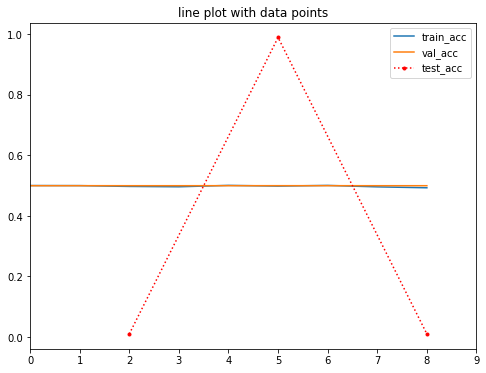

In [26]:
evaluate_model(histories_000, Y_test_000, Y_predicts_000)

cycle: 0


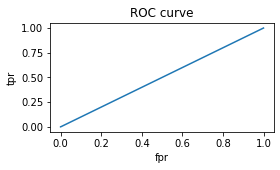

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


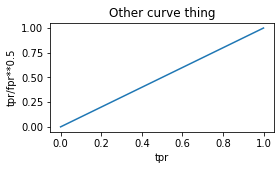

cycle: 1


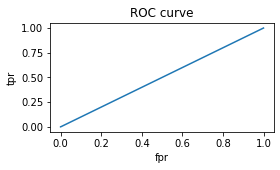

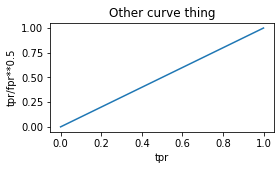

cycle: 2


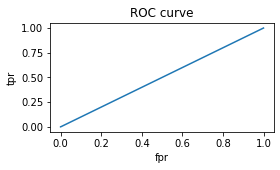

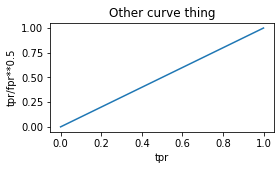

In [43]:
final_evaluation(Y_test_000, Y_predicts_000)

#### fifteen percent siggy

In [19]:
Phi_sizes, F_sizes = (80, 60, 60), (60,40,40)
num_epoch = 12
num_cycles = 3
batch_size = 100

In [22]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data_modified(X_bg, X_sig, 0.15)

training
22798
129195
validation
13679
77516
Training set size, distribution:
(303986, 282, 4)
(array([0., 1.]), array([151993, 151993]))
Validations set size, distribution:
(182390, 282, 4)
(array([0., 1.]), array([91195, 91195]))
Test set size, distribution:
(39356, 282, 4)
(array([0., 1.]), array([19678, 19678]))


In [23]:
histories_015, Y_test_015, Y_predicts_015, model_015 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 80)     400         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 80)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 60)     4860        activation_1[0][0]               
__________________________________________________________________________________________________
activation

Epoch 6/12
303986/303986 [==============================] - 24s 77us/step - loss: 0.6913 - acc: 0.5283 - val_loss: 0.6913 - val_acc: 0.5277
Epoch 7/12
303986/303986 [==============================] - 24s 78us/step - loss: 0.6912 - acc: 0.5278 - val_loss: 0.6913 - val_acc: 0.5280
Epoch 8/12
303986/303986 [==============================] - 24s 78us/step - loss: 0.6913 - acc: 0.5282 - val_loss: 0.6913 - val_acc: 0.5277
Epoch 9/12
303986/303986 [==============================] - 24s 78us/step - loss: 0.6913 - acc: 0.5279 - val_loss: 0.6917 - val_acc: 0.5260
Epoch 10/12
303986/303986 [==============================] - 24s 78us/step - loss: 0.6913 - acc: 0.5280 - val_loss: 0.6913 - val_acc: 0.5278
Epoch 11/12
303986/303986 [==============================] - 24s 78us/step - loss: 0.6913 - acc: 0.5279 - val_loss: 0.6914 - val_acc: 0.5283
Epoch 12/12
303986/303986 [==============================] - 24s 78us/step - loss: 0.6913 - acc: 0.5278 - val_loss: 0.6914 - val_acc: 0.5282


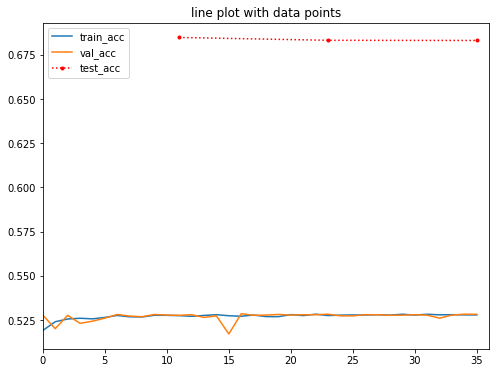

In [24]:
evaluate_model(histories_015, Y_test_015, Y_predicts_015)

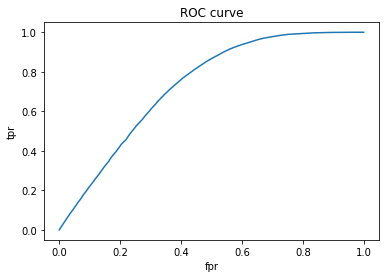

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


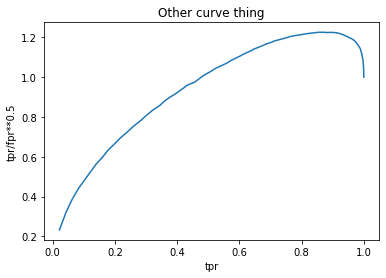

In [25]:
final_evaluation(Y_test_015, Y_predicts_015[-1:])

#### 5 percent signal



##### Training and stuff

In [36]:
Phi_sizes, F_sizes =  (80, 60, 60), (60,40,40)
num_epoch = 3
num_cycles = 3
batch_size = 10


In [35]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data_modified(X_bg, X_sig, 0.05)

training
7599
144394
validation
4559
86636
test
19678
Training set size, distribution:
(303986, 282, 4)
(array([0., 1.]), array([151993, 151993]))
Validations set size, distribution:
(182390, 282, 4)
(array([0., 1.]), array([91195, 91195]))
Test set size, distribution:
(39356, 282, 4)
(array([0., 1.]), array([19678, 19678]))


In [37]:
histories_005, Y_test_005, Y_predicts_005, model_005 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 80)     400         input[0][0]                      
__________________________________________________________________________________________________
activation_22 (Activation)      (None, None, 80)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 60)     4860        activation_22[0][0]              
__________________________________________________________________________________________________
activation

##### output

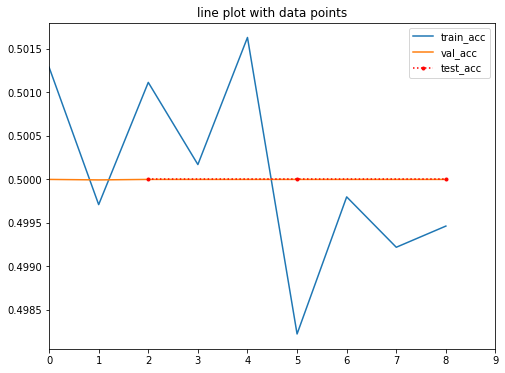

In [38]:
evaluate_model(histories_005, Y_test_005, Y_predicts_005)

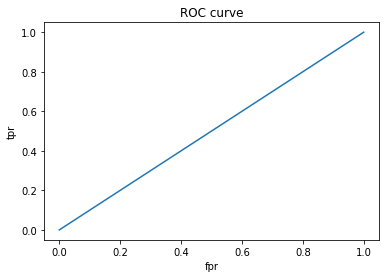

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


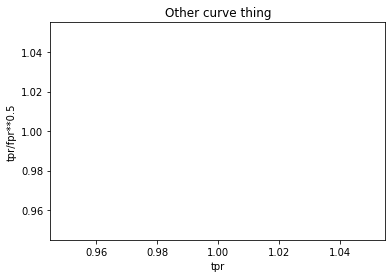

In [39]:
final_evaluation(Y_test_005, Y_predicts_005[-1:])

#### 6 percent?

##### training and stuff

In [118]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data_modified(X_bg, X_sig, 0.05, normalize_all=False)

training
516
9817
validation
309
5890
Training set size, distribution:
(20666, 282, 4)
(array([0., 1.]), array([10333, 10333]))
Validations set size, distribution:
(12398, 282, 4)
(array([0., 1.]), array([6199, 6199]))
Test set size, distribution:
(8265, 282, 4)
(array([0., 1.]), array([4133, 4132]))


In [119]:
histories_006, Y_test_006, Y_predicts_006, model_006 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 80)     400         input[0][0]                      
__________________________________________________________________________________________________
activation_93 (Activation)      (None, None, 80)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 40)     3240        activation_93[0][0]              
__________________________________________________________________________________________________
activation

##### output

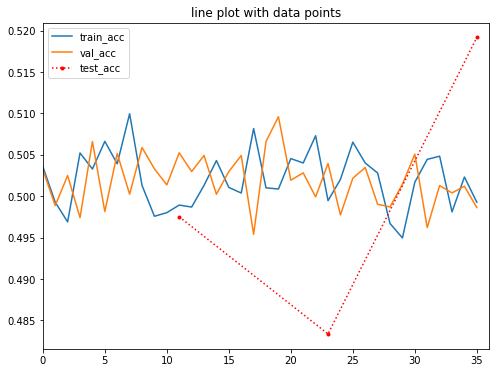

In [120]:
evaluate_model(histories_006, Y_test_006, Y_predicts_006)

#### 14 percent?

In [138]:
Phi_sizes, F_sizes = (40, 20, 20), (20,20,20)
num_epoch = 8
num_cycles = 3
batch_size = 20


In [139]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data_modified(X_bg, X_sig, 0.14)

training
1446
8887
validation
867
5332
Training set size, distribution:
(20666, 282, 4)
(array([0., 1.]), array([10333, 10333]))
Validations set size, distribution:
(12398, 282, 4)
(array([0., 1.]), array([6199, 6199]))
Test set size, distribution:
(8265, 282, 4)
(array([0., 1.]), array([4133, 4132]))


In [140]:
histories_014, Y_test_014, Y_predicts_014, model_014 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 40)     200         input[0][0]                      
__________________________________________________________________________________________________
activation_114 (Activation)     (None, None, 40)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 20)     820         activation_114[0][0]             
__________________________________________________________________________________________________
activation

#### 4.1

In [17]:
Phi_sizes, F_sizes = (80, 40, 20), (50,40,40)
num_epoch = 3
num_cycles = 3
batch_size = 100
histories_42, Y_test_42, Y_predicts_42, model_42 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 80)     400         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, None, 80)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 40)     3240        activation_15[0][0]              
__________________________________________________________________________________________________
activation

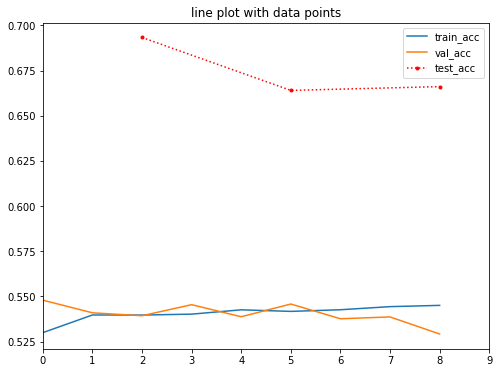

In [18]:
evaluate_model(histories_42, Y_test_42, Y_predicts_42)

Text(0.5, 1.0, 'ROC curve')

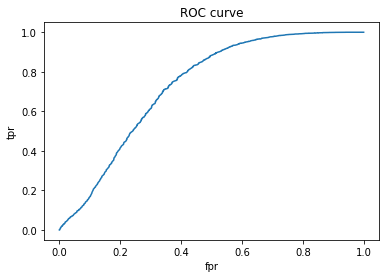

In [19]:
import sklearn
roc_curve = sklearn.metrics.roc_curve(Y_test_42[:,1:], Y_predicts_42[-1][:,1:])

plt.plot(roc_curve[0],roc_curve[1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'ROC curve')

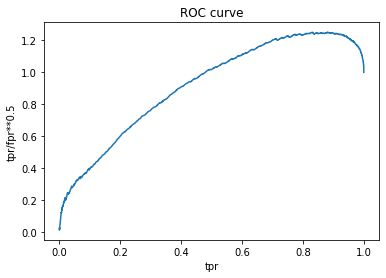

In [20]:
plt.plot(roc_curve[1],roc_curve[1]/roc_curve[0]**0.5)
plt.xlabel('tpr')
plt.ylabel('tpr/fpr**0.5')
plt.title('ROC curve')

In [ ]:
Phi_sizes, F_sizes = (120, 60, 60), (120,60,60)
num_epoch = 8
num_cycles = 3
batch_size = 100
histories_42, Y_test_42, Y_predicts_42, model_42 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

#### Attempt 6: 1 percent siggggg

In [20]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0.05, use_pid=True, normalize_all=True)

Size of sb:
(76000, 282, 4)
Size of bgsig:
(72200, 282, 4)
Size of sig:
(3800, 282, 4)
Training set size, distribution:
(121600, 282, 4)
(array([0., 1.]), array([60706, 60894]))
Validations set size, distribution:
(30400, 282, 4)
(array([0., 1.]), array([15294, 15106]))
Test set size, distribution:
(10000, 282, 4)
(array([0., 1.]), array([5000, 5000]))


In [21]:
Phi_sizes, F_sizes = (80, 40, 40), (80,60,60)
num_epoch = 3
num_cycles = 3
batch_size = 10
histories_61, Y_test_61, Y_predicts_61, model_61 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 80)     400         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, None, 80)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 40)     3240        activation_15[0][0]              
__________________________________________________________________________________________________
activation

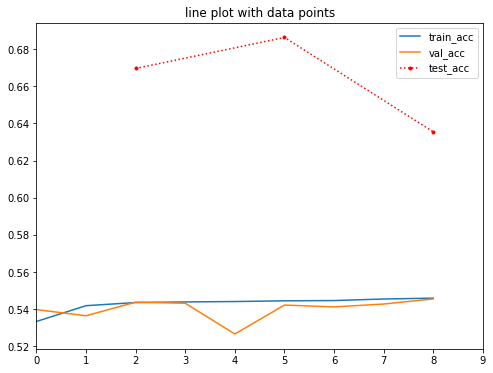

In [23]:
evaluate_model(histories_61, Y_test_61, Y_predicts_61)

Text(0.5, 1.0, 'ROC curve')

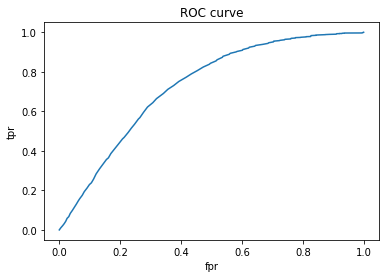

In [24]:
roc_curve = sklearn.metrics.roc_curve(Y_test_61[:,1:], Y_predicts_61[-1][:,1:])

plt.plot(roc_curve[0],roc_curve[1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'ROC curve')

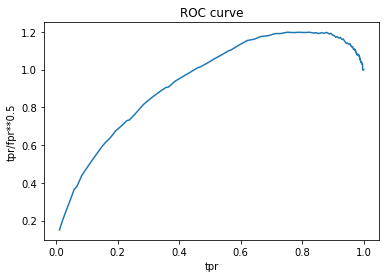

In [25]:
plt.plot(roc_curve[1],roc_curve[1]/roc_curve[0]**0.5)
plt.xlabel('tpr')
plt.ylabel('tpr/fpr**0.5')
plt.title('ROC curve')

#### Attempt 5: 90 signal

In [16]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0.9, use_pid = True, normalize_all=True)

Size of sb:
(76000, 282, 4)
Size of bgsig:
(7600, 282, 4)
Size of sig:
(68400, 282, 4)
Training set size, distribution:
(121600, 282, 4)
(array([0., 1.]), array([60931, 60669]))
Validations set size, distribution:
(30400, 282, 4)
(array([0., 1.]), array([15069, 15331]))
Test set size, distribution:
(10000, 282, 4)
(array([0., 1.]), array([5000, 5000]))


In [17]:
histories_5, Y_test_5, Y_predicts_5, model_5 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 40)     200         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 40)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 20)     820         activation_7[0][0]               
__________________________________________________________________________________________________
activation

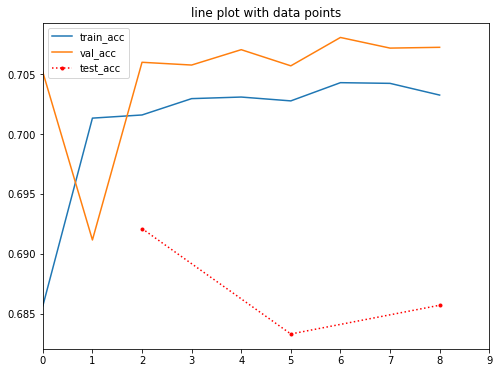

In [18]:
evaluate_model(histories_5, Y_test_5, Y_predicts_5)